In this example we are going to fetch live data for 6 different locations [concurrently](https://docs.python.org/3/library/concurrency.html). With the acquired data we are going to explore the average hourly GHI for the 6 different locations. 

We will be using [timezoneidentifier](https://timezonefinder.readthedocs.io/en/latest/index.html) to automatically translate a location to a timezone so that we can compare locations across different timezones. 

In [ ]:
!pip install timezonefinder

In [1]:
import concurrent
from timezonefinder import TimezoneFinder
from functools import partial
import pandas as pd

from solcast.unmetered_locations import UNMETERED_LOCATIONS
from solcast import live

we fix the `output_parameter` of the `live.radaition_and_weather` call as this will be common for all sites 

In [2]:
radiation_and_weather = partial(live.radiation_and_weather, output_parameters='ghi')

We'll be fetching concurrently the GHI for all the unmetered locations

In [3]:
with concurrent.futures.ThreadPoolExecutor(3) as thread_pool:
    futures = thread_pool.map(
        lambda f: radiation_and_weather(*f), [
            (UNMETERED_LOCATIONS[site]['latitude'], UNMETERED_LOCATIONS[site]['longitude']) for site in UNMETERED_LOCATIONS
        ]
    )
    
res = list(futures)

for each of the 6 unmetered locations we:

    - fetch the data from the API
    - find the right timezone for each location
    - group by the hour and take the mean of the GHI
    - concatenate the data

In [4]:
tmz_finder = TimezoneFinder()
dfs = []

for i, name  in enumerate(UNMETERED_LOCATIONS):
    tmz = tmz_finder.timezone_at(
        lng=UNMETERED_LOCATIONS[name]['longitude'], lat=UNMETERED_LOCATIONS[name]['latitude']
    )
    df = res[i].to_pandas().rename(columns={'ghi': name})
    df.index=df.index.tz_convert(tmz)
    df = df.groupby(df.index.hour).mean()
    dfs.append(df)

dfs = pd.concat(dfs, axis=1)

Let's plot the results:

<Axes: xlabel='period_end'>

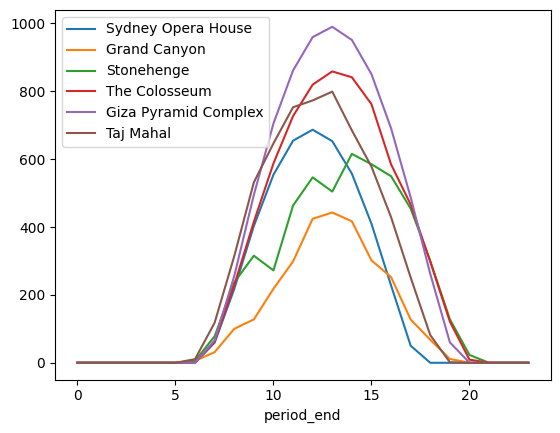

In [5]:
dfs.plot()